In [135]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import ShuffleSplit, train_test_split 
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from scipy import stats
plt.style.use('ggplot')

In [136]:
train_df = pd.read_csv('train_kmart.csv')
test_df = pd.read_csv('test_kmart.csv')

In [137]:
train_df.shape

(8523, 12)

In [138]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [139]:
#Check the basic statistical information
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


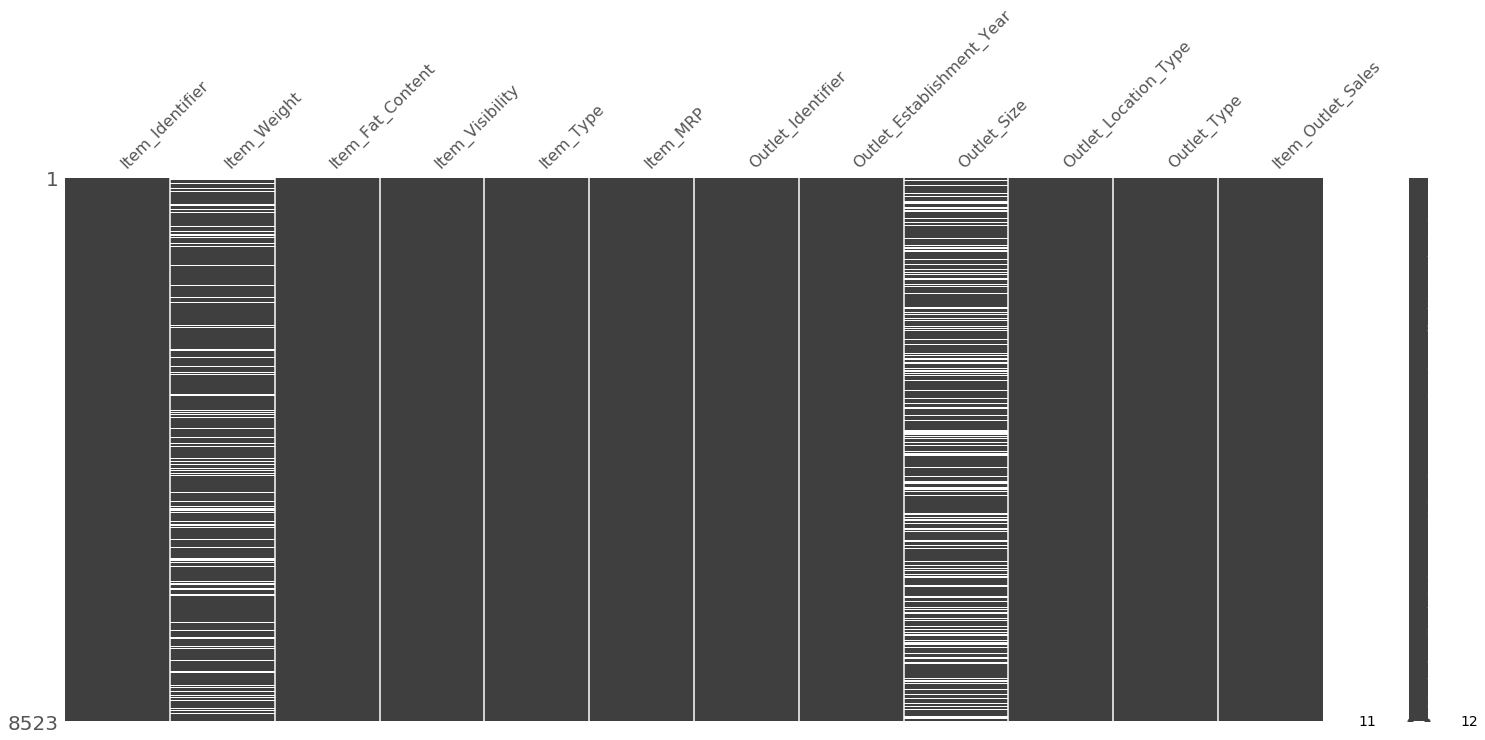

In [140]:
#Check the missing value
msno.matrix(train_df)

In [141]:
#check missing value in all columns
train_df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [142]:
for col in train_df.columns:
    print(col,len(train_df[col].unique()))

Item_Identifier 1559
Item_Weight 416
Item_Fat_Content 5
Item_Visibility 7880
Item_Type 16
Item_MRP 5938
Outlet_Identifier 10
Outlet_Establishment_Year 9
Outlet_Size 4
Outlet_Location_Type 3
Outlet_Type 4
Item_Outlet_Sales 3493


In [143]:
# Print the the column with unique values which are less than 20 
for col in train_df.columns:
    if len(train_df[col].unique())<20:
        print(col,train_df[col].unique() )

Item_Fat_Content ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Item_Type ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Outlet_Identifier ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Outlet_Establishment_Year [1999 2009 1998 1987 1985 2002 2007 1997 2004]
Outlet_Size ['Medium' nan 'High' 'Small']
Outlet_Location_Type ['Tier 1' 'Tier 3' 'Tier 2']
Outlet_Type ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


# Pre-processing

### Impute the missing value in column  Item_Weight with mean

In [144]:
# Impute the missing value in column Item_Weight with Item_Weight mean of same item identifier
train_df['Item_Weight'] = train_df.groupby('Item_Identifier')['Item_Weight'].apply(lambda x: x.fillna(x.mean()))
#delete the row in which null value in Item_Weight   
train_df = train_df[pd.notnull(train_df['Item_Weight'])]
test_df['Item_Weight'] = test_df.groupby('Item_Identifier')['Item_Weight'].apply(lambda x: x.fillna(x.mean()))
#test_df = test_df[pd.notnull(test_df['Item_Weight'])]

### Unify the input of Item_Fat_Content 

In [145]:
# check the unique values item_fat_content contains
train_df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [146]:
train_df['Item_Fat_Content'] =train_df['Item_Fat_Content'].replace(['LF', 'low fat', 'reg'], ['Low Fat','Low Fat', 'Regular'])
test_df['Item_Fat_Content'] =test_df['Item_Fat_Content'].replace(['LF', 'low fat', 'reg'], ['Low Fat','Low Fat', 'Regular'])

### Impute the missing value(item_visibility = 0) with mean

In [147]:
#the percentaage of item visibility =0 in all item visibility
len(train_df[train_df['Item_Visibility'] == float(0)])/len(train_df)

0.061744336189693626

In [148]:
#replace 0 with nan
train_df.loc[train_df['Item_Visibility'] == float(0),'Item_Visibility'] = np.nan
#train_df['Item_Visibility'][train_df['Item_Visibility'] == float(0)]= np.nan
#Impute the missing value in column Item_Visibility with Item_Visibility mean of same item identifier
train_df['Item_Visibility'] = train_df.groupby('Item_Identifier')['Item_Visibility'].apply(lambda x: x.fillna(x.mean()))
#test data
test_df.loc[test_df['Item_Visibility'] == float(0),'Item_Visibility']= np.nan
test_df['Item_Visibility'] = test_df.groupby('Item_Identifier')['Item_Visibility'].apply(lambda x: x.fillna(x.mean()))

### Impute the missing value in column = Outlet_Size using KNN model

In [149]:
# make a copy of train_df
train_data = train_df.copy()
#Convert categorical column into one hot encoder
train_data_cat =pd.get_dummies(train_data, columns=["Item_Fat_Content", "Item_Type", "Outlet_Identifier", 'Outlet_Location_Type','Outlet_Type'], prefix=["Item_Fat_Content","Item_Type", "Outlet_Identifier", 'Outlet_Location_Type','Outlet_Type'], drop_first = True)
#Add column Outlet_Identifier for later missing value imputation use
train_data_cat['Outlet_Identifier'] = train_data['Outlet_Identifier']

# Cut the train data into dataset with outlet size or without outlet size 
train_data_notnull = train_data_cat[train_data['Outlet_Size'].notnull()]
train_data_null = train_data_cat[train_data['Outlet_Size'].isnull() ]
train_data_notnull['Outlet_Size'] = train_data_notnull['Outlet_Size'].map({'Small':0, 'Medium':1, 'High': 2})

/home/xy990/pytorch-cpu/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [153]:
#Separate the datasets into feature values and target variable
X = train_data_notnull.drop(['Item_Identifier','Outlet_Size','Outlet_Identifier', 'Item_Outlet_Sales'],axis=1)
Y = train_data_notnull['Outlet_Size']

#Split the datasets into train data and test data 0.75/0.25
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

#Build knn model
knn = KNeighborsClassifier()

#Do gridsearch on KNN
param_grid = {'n_neighbors': list(range(1,20,2))}
CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid,cv=10, scoring='accuracy')
CV_knn.fit(X_train, Y_train)
print('Test Acc: %.2f' % CV_knn.score(X_test,Y_test))
#Print the parameters in the best model
print(CV_knn.best_params_)
#print(CV_knn.grid_scores_)
#print(CV_knn.cv_results_)

/home/xy990/pytorch-cpu/py3.6.3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Test Acc: 0.95
{'n_neighbors': 1}


In [155]:
# Build knn model with the tuned parameter 
model = KNeighborsClassifier(n_neighbors =1)

# Train the model using the training sets
model.fit(train_data_notnull.drop(['Item_Identifier','Outlet_Size','Outlet_Identifier','Item_Outlet_Sales'],axis=1),train_data_notnull['Outlet_Size'])

#Predict Output
predicted= model.predict(train_data_null.drop(['Item_Identifier','Outlet_Size','Outlet_Identifier','Item_Outlet_Sales'],axis=1)) # 0:Overcast, 2:Mild

In [156]:
# Impute the missing value with predicted value by knn model
train_data_null['Outlet_Size'] = predicted

/home/xy990/pytorch-cpu/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [157]:
# Check the missing value appears in which outlet_identifier
train_data_null['Outlet_Identifier'].unique()

array(['OUT010', 'OUT045', 'OUT017'], dtype=object)

In [158]:
# Unify the outlet size of the same outlet identifier with the value appears most commonly
train_data_null.groupby('Outlet_Identifier')['Outlet_Size'].agg(lambda x: x.value_counts().index[0])

Outlet_Identifier
OUT010    1
OUT017    1
OUT045    0
Name: Outlet_Size, dtype: int64

In [159]:
# Impute the missing value of outlet size with most common value group by outlet identifier
train_data_null.loc[train_data_null['Outlet_Identifier'] == 'OUT010', 'Outlet_Size'] = 1
train_data_null.loc[train_data_null['Outlet_Identifier'] == 'OUT017', 'Outlet_Size'] = 1
train_data_null.loc[train_data_null['Outlet_Identifier'] == 'OUT045', 'Outlet_Size'] = 0

/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/pandas-0.22.0-py3.6-linux-x86_64.egg/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [160]:
# Concatenate to get full train data
train_data_cleaned = pd.concat([train_data_notnull,train_data_null])

In [161]:
train_target = train_data_cleaned['Item_Outlet_Sales']

In [24]:
#test_df

In [162]:
test_data_cat =pd.get_dummies(test_df, columns=["Item_Fat_Content", "Item_Type", "Outlet_Identifier", 'Outlet_Location_Type','Outlet_Type'], prefix=["Item_Fat_Content","Item_Type", "Outlet_Identifier", 'Outlet_Location_Type','Outlet_Type'],drop_first=True)


#Add back column Outlet_Identifier for later imputating missing value in column outlet size
test_data_cat['Outlet_Identifier'] = test_df['Outlet_Identifier']
# Cut the train data into dataset with outlet size or without outlet size 
test_data_notnull = test_data_cat[test_data_cat['Outlet_Size'].notnull()]
test_data_null = test_data_cat[test_data_cat['Outlet_Size'].isnull()]
# Impute the missing value of outlet size with the same value imputed in the training set
test_data_null.loc[test_data_null['Outlet_Identifier'] == 'OUT010', 'Outlet_Size'] = 1
test_data_null.loc[test_data_null['Outlet_Identifier'] == 'OUT017', 'Outlet_Size'] = 1
test_data_null.loc[test_data_null['Outlet_Identifier'] == 'OUT045', 'Outlet_Size'] = 0

# Concatenate to get full train data
test_data_cleaned = pd.concat([test_data_notnull,test_data_null])
#Drop the target variable of train set for later align one hot encoder of train set and test set 
train_data_cleaned = train_data_cleaned.drop(['Item_Outlet_Sales'], axis=1)

#align train data with test data transformation
train_data_cleaned, test_data_cleaned = train_data_cleaned.align(test_data_cleaned,
                                                                    join='left', 
                                                                    axis=1)

In [163]:
train_data_cleaned['Item_Outlet_Sales'] = train_target

### Exploration of target variable

/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/scipy-1.0.0rc1-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Sales')

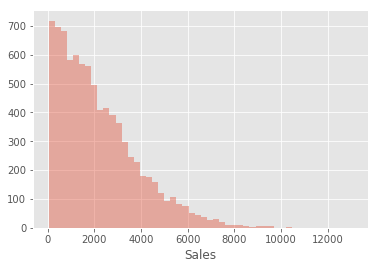

In [27]:
import seaborn as sns
sns.distplot(train_data_cleaned['Item_Outlet_Sales'], kde=None)
plt.xlabel('Sales')

In [124]:

# drop Item_Identifier and Outlet_Identifier
train_data_cleaned = train_data_cleaned.drop(['Item_Identifier','Outlet_Identifier'],axis =1)
test_data_cleaned = test_data_cleaned.drop(['Item_Identifier','Outlet_Identifier'],axis =1)

# Feature Selection

In [76]:
X= train_data_cleaned.drop(['Item_Outlet_Sales'],axis =1) 
Y= train_data_cleaned['Item_Outlet_Sales']
#Split the datasets into train data and test data 0.8/0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.8)


/home/xy990/pytorch-cpu/py3.6.3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [77]:
# Build a gradient boosting regression tree baseline model 
gbrt=GradientBoostingRegressor(random_state =10)
gbrt.fit(X_train, Y_train) 
Y_pred=gbrt.predict(X_test)

In [78]:
print("Features sorted by their score:")
#print(sorted(zip(map(lambda x: round(x, 4), gbrt.feature_importances_), X_train.columns), reverse=True))
print("R-squared for Train: %.2f" %gbrt.score(X_train, Y_train)) 
print("R-squared for Test: %.2f" %gbrt.score(X_test, Y_test))

Features sorted by their score:
R-squared for Train: 0.63
R-squared for Test: 0.59


### Plot the feature importances

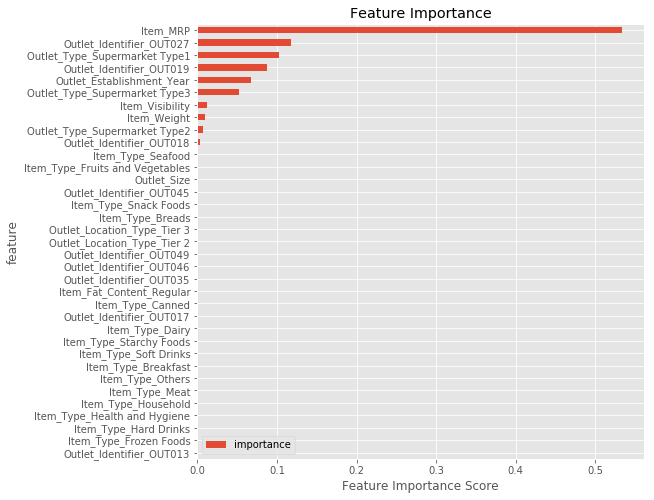

                                 importance
feature                                    
Item_MRP                              0.534
Outlet_Identifier_OUT027              0.118
Outlet_Type_Supermarket Type1         0.102
Outlet_Identifier_OUT019              0.087
Outlet_Establishment_Year             0.067
Outlet_Type_Supermarket Type3         0.052
Item_Visibility                       0.012
Item_Weight                           0.010
Outlet_Type_Supermarket Type2         0.007
Outlet_Identifier_OUT018              0.003
Item_Type_Seafood                     0.001
Item_Type_Fruits and Vegetables       0.001
Outlet_Size                           0.001
Outlet_Identifier_OUT045              0.001
Item_Type_Snack Foods                 0.001
Item_Type_Breads                      0.001
Outlet_Location_Type_Tier 3           0.000
Outlet_Location_Type_Tier 2           0.000
Outlet_Identifier_OUT049              0.000
Outlet_Identifier_OUT046              0.000
Outlet_Identifier_OUT035        

In [79]:
feat_importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(gbrt.feature_importances_,3)})
feat_importances = feat_importances.sort_values('importance',ascending=False).set_index('feature')
feat_importances[::-1].plot.barh(title='Feature Importance', figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

print(feat_importances)
        

In [80]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=.8)

/home/xy990/pytorch-cpu/py3.6.3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [81]:
from sklearn import metrics 
# fit model using each importance as a threshold
thresholds = sorted(gbrt.feature_importances_)
for thresh in thresholds:
    # selecting features using threshold
    selection = SelectFromModel(gbrt, threshold=thresh, prefit=True)
    select_train_x = selection.transform(X_train)
    #print(select_train_x.shape)
    
    # training model
    selection_model =GradientBoostingRegressor(n_estimators=100)
    selection_model.fit(select_train_x, Y_train)
    
    # evaluating model
    select_val_x = selection.transform(X_val)
    pred_y = selection_model.predict(select_val_x)
    predictions = [round(value) for value in pred_y]
    r_square = metrics.r2_score(Y_val, predictions)
    adj_r_square = 1 - float(len(Y_val)-1)/(len(Y_val)-select_train_x.shape[1]-1)*(1 - metrics.r2_score(Y_val,predictions))
    
    print("Thresh=%.3f, n=%d, R_Square: %.4f, Adj_R_Square: %.4f" % (thresh, select_train_x.shape[1], r_square, adj_r_square))



Thresh=0.000, n=35, R_Square: 0.5864, Adj_R_Square: 0.5755
Thresh=0.000, n=35, R_Square: 0.5862, Adj_R_Square: 0.5753
Thresh=0.000, n=35, R_Square: 0.5858, Adj_R_Square: 0.5749
Thresh=0.000, n=35, R_Square: 0.5866, Adj_R_Square: 0.5757
Thresh=0.000, n=35, R_Square: 0.5864, Adj_R_Square: 0.5755
Thresh=0.000, n=30, R_Square: 0.5870, Adj_R_Square: 0.5776
Thresh=0.000, n=29, R_Square: 0.5866, Adj_R_Square: 0.5776
Thresh=0.000, n=28, R_Square: 0.5865, Adj_R_Square: 0.5778
Thresh=0.000, n=27, R_Square: 0.5857, Adj_R_Square: 0.5773
Thresh=0.000, n=26, R_Square: 0.5861, Adj_R_Square: 0.5780
Thresh=0.000, n=25, R_Square: 0.5847, Adj_R_Square: 0.5769
Thresh=0.000, n=24, R_Square: 0.5862, Adj_R_Square: 0.5788
Thresh=0.000, n=23, R_Square: 0.5856, Adj_R_Square: 0.5784
Thresh=0.000, n=22, R_Square: 0.5859, Adj_R_Square: 0.5791
Thresh=0.000, n=21, R_Square: 0.5821, Adj_R_Square: 0.5755
Thresh=0.000, n=20, R_Square: 0.5834, Adj_R_Square: 0.5772
Thresh=0.000, n=19, R_Square: 0.5816, Adj_R_Square: 0.57

### According to the Adjusted R square and results get by baseline linear regression model , we can choose the top 9  features with the most important feature importance. 

### Build Model

In [83]:


X= train_data_cleaned[feat_importances[:9].index.values] 
Y= train_data_cleaned['Item_Outlet_Sales']

#Split the datasets into train data and test data 0.8/0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.8)

/home/xy990/pytorch-cpu/py3.6.3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### baseline Ridge regression

In [84]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha =0.5)
reg.fit(X_train, Y_train) 

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [85]:
print ("Train R-squared: %.2f" %reg.score(X_train,Y_train)) 
print ("Test R-squared: %.2f" %reg.score(X_test,Y_test)) 

adj_r_square = 1 - float(len(Y_test)-1)/(len(Y_test)-20-1)*(1 - metrics.r2_score(Y_test,reg.predict(X_test)))
print ('adj_r_square: %.2f' % adj_r_square)   

Train R-squared: 0.57
Test R-squared: 0.55
adj_r_square: 0.54


In [86]:
# Use cross validation to find best parameters
from sklearn.metrics import r2_score, make_scorer
r2_scorer = make_scorer(r2_score)
def GradientBooster(param_grid, n_jobs,random_state = 10):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit( n_splits = 20, test_size=0.2)
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs,scoring=r2_scorer)
    classifier.fit(X_train, Y_train)
    print("Best Estimator learned through GridSearch") 
    print(classifier.best_estimator_)
    return cv, classifier.best_estimator_ 

In [87]:
param_grid={'n_estimators':[250,300,400], 
            'learning_rate': [ 0.01,0.015, 0.02], 
            'max_depth': list(range(3,10,2)), 
            'min_samples_split': [50,60,70,80],
            } 
n_jobs=4 
cv,best_est=GradientBooster(param_grid, n_jobs)

Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.02, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=80, min_weight_fraction_leaf=0.0,
             n_estimators=300, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)


In [88]:
from sklearn.metrics import mean_squared_error
print("Best Estimator Parameters" )
print("---------------------------") 
print("n_estimators: %d" %best_est.n_estimators)
print("max_depth: %d" %best_est.max_depth)
print("Learning Rate: %.2f"  %best_est.learning_rate) 
print("min_samples_leaf: %d" %best_est.min_samples_leaf) 
#print("max_features: %.1f" %best_est.max_features) 
 
print ("Train R-squared: %.2f" %best_est.score(X_train,Y_train)) 
print ("Test R-squared: %.2f" %best_est.score(X_test,Y_test)) 
mse = mean_squared_error(Y_test, best_est.predict(X_test))
print("MSE: %.4f" % mse)

Best Estimator Parameters
---------------------------
n_estimators: 300
max_depth: 3
Learning Rate: 0.02
min_samples_leaf: 1
Train R-squared: 0.62
Test R-squared: 0.58
MSE: 1143150.7612


# Plot residual 

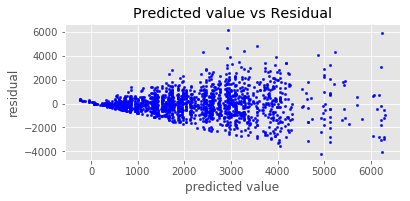

In [89]:
residual = Y_test - best_est.predict(X_test)
fig, ax = plt.subplots(figsize=(6,2.5))
ax.scatter(best_est.predict(X_test), residual,s=5, c='b', marker="o")
plt.xlabel('predicted value')
plt.ylabel('residual')
plt.title('Predicted value vs Residual')
plt.show()

### The plot shows very obvious heteroscedasticity. When predicted value is small, the majority residuals locate around 0. When predicted value becomes larger, the residual does not stick in around 0 but disperse more sparsely in a larger range with center 0.  

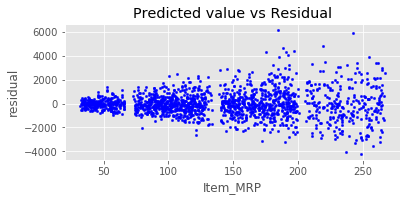

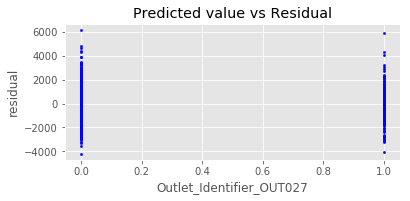

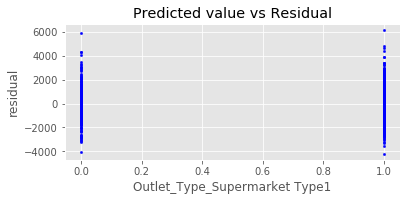

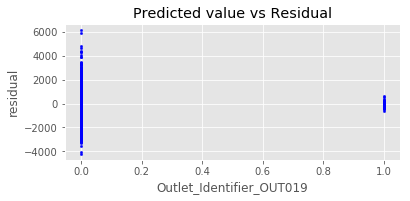

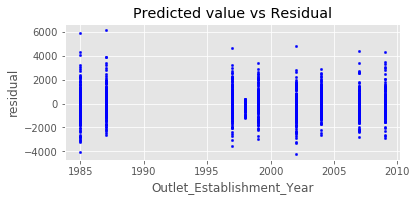

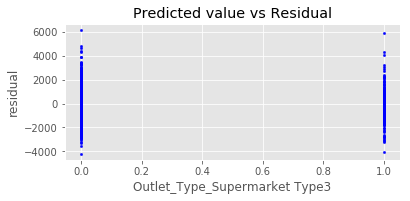

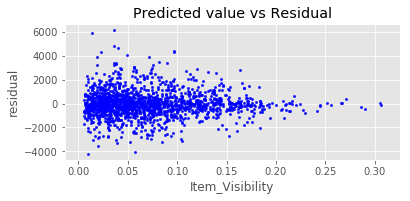

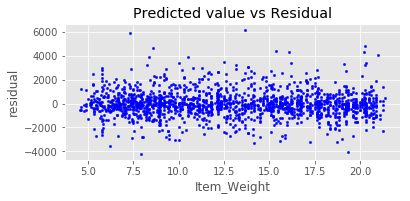

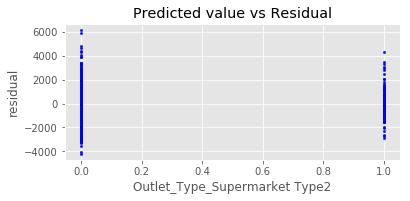

In [90]:
for i in X_test.columns:
    residual = Y_test - best_est.predict(X_test)
    fig, ax = plt.subplots(figsize=(6,2.5))
    ax.scatter(X_test[i], residual,s=5, c='b', marker="o")
    plt.xlabel(str(i))
    plt.ylabel('residual')
    plt.title('Predicted value vs Residual')
    plt.show()

### The relationship between Item_MRP and residual is similar to the relationship between predicted value and residual. 

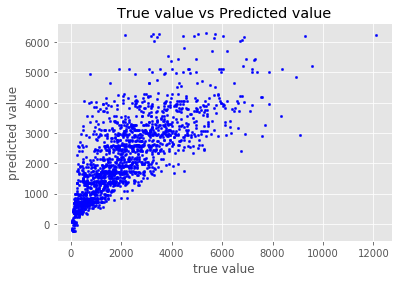

In [91]:
plt.scatter(Y_test, best_est.predict(X_test), s=5, c='b', marker="o")
plt.xlabel('true value')
plt.ylabel('predicted value')
plt.title('True value vs Predicted value')
plt.show()

In [ ]:
# take the log norm of target variable

In [92]:
X= train_data_cleaned[feat_importances[:9].index.values] 
Y= np.log(train_data_cleaned['Item_Outlet_Sales'])

#Split the datasets into train data and test data 0.8/0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.8)

/home/xy990/pytorch-cpu/py3.6.3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [93]:
# Use cross validation to 
from sklearn.metrics import r2_score, make_scorer
r2_scorer = make_scorer(r2_score)
def GradientBooster(param_grid, n_jobs,random_state = 10):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit( n_splits = 20, test_size=0.2)
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs,scoring=r2_scorer)
    classifier.fit(X_train, Y_train)
    print("Best Estimator learned through GridSearch") 
    print(classifier.best_estimator_)
    return cv, classifier.best_estimator_ 

In [94]:
param_grid={'n_estimators':[250,300,400], 
            'learning_rate': [0.005, 0.01,0.015, 0.02], 
            'max_depth': list(range(2,10,2)), 
            'min_samples_split': [50,60,70,80],
            } 
n_jobs=4 
cv,best_est=GradientBooster(param_grid, n_jobs)

Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.015, loss='ls', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=60,
             min_weight_fraction_leaf=0.0, n_estimators=400,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)


In [97]:
from sklearn.metrics import mean_squared_error
print("Best Estimator Parameters" )
print("---------------------------") 
print("n_estimators: %d" %best_est.n_estimators)
print("max_depth: %d" %best_est.max_depth)
print("Learning Rate: %.2f"  %best_est.learning_rate) 
print("min_samples_split: %d" %best_est.min_samples_split) 
#print("max_features: %.1f" %best_est.max_features) 
 
print ("Train R-squared: %.2f" %best_est.score(X_train,Y_train)) 
print ("Test R-squared: %.2f" %best_est.score(X_test,Y_test)) 
mse = mean_squared_error(Y_test, best_est.predict(X_test))
print("MSE: %.4f" % mse)

Best Estimator Parameters
---------------------------
n_estimators: 400
max_depth: 4
Learning Rate: 0.01
min_samples_split: 60
Train R-squared: 0.75
Test R-squared: 0.75
MSE: 0.2661


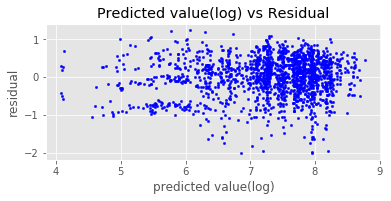

In [96]:
residual = Y_test - best_est.predict(X_test)
fig, ax = plt.subplots(figsize=(6,2.5))
ax.scatter(best_est.predict(X_test), residual,s=5, c='b', marker="o")
plt.xlabel('predicted value(log)')
plt.ylabel('residual')
plt.title('Predicted value(log) vs Residual')
plt.show()

### The plot still shows heteroscedasticity.

### Test Data Prediction 

In [165]:
test_data_cleaned = test_data_cleaned.fillna(0)

In [166]:
np.exp(best_est.predict(test_data_cleaned[feat_importances[:9].index.values]) )

array([1279.3603194 , 5337.64783682, 1671.63388684, ..., 1677.34304682,
       3155.06222415, 1177.26991231])

In [167]:
test_df['Item_Outlet_Sales'] = np.exp(best_est.predict(test_data_cleaned[feat_importances[:9].index.values]) )

In [168]:
test_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,1279.360319
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1,5337.647837
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store,1671.633887
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1,518.380269
4,FDY38,13.600,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,1882.106617


In [169]:
test_df.to_csv('kmart_test_withsale.csv')